# 데이터 준비

Chest X-Ray Images (Pneumonia)
https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

\# 클라우드 생성 및 데이터 불러오기

$ mkdir -p ~/aiffel/chest_xray

$ ln -s ~/data/ ~/aiffel/chest_xray

# 패키지(라이브러리) import 

# 1. Set-up

In [1]:
import re
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# 데이터 ROOT 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')

# BATCH_SIZE 변수
BATCH_SIZE = 16

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# EPOCH 크기 변수
EPOCHS = 20

# 2. 데이터 가져오기

In [3]:
train_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/data/train/*/*'))
test_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/data/test/*/*'))
val_filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/data/val/*/*'))

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [4]:
filenames = tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/data/train/*/*'))
filenames.extend(tf.io.gfile.glob(str(ROOT_PATH + '/chest_xray/data/val/*/*')))

train_filenames, val_filenames = train_test_split(filenames, test_size=0.2)

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [5]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

Normal images count in training set: 1071
Pneumonia images count in training set: 3114


In [6]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [7]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))

Training images count: 4185
Validating images count: 1047


In [8]:
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(ROOT_PATH + "/chest_xray/data/train/*/*"))])
print(CLASS_NAMES)

['NORMAL2-IM-1332-0001.jpeg' 'IM-0176-0001.jpeg'
 'NORMAL2-IM-1011-0001.jpeg' ... 'person1551_bacteria_4054.jpeg'
 'person1918_bacteria_4825.jpeg' 'person942_bacteria_2867.jpeg']


In [9]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)를 리턴하게 합니다.

In [10]:
def decode_img(img):
  # 이미지를 uint8 tensor로 바꾼다.
  img = tf.image.decode_jpeg(img, channels=3)
  # img를 범위 [0,1]의 float32 데이터 타입으로 바꾼다.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # img의 이미지 사이즈를 IMAGE_SIZE에서 지정한 사이즈로 수정한다.
  return tf.image.resize(img, IMAGE_SIZE)

def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [11]:
# train 데이터 셋과 validation 데이터 셋 만들기
# num_parallel_calls 파라미터에 위에서 할당한 AUTOTUNE변수를 이용하면 더욱 빠르게 데이터를 처리가능

train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [12]:
# 이미지 리사이즈 및 라벨 확인

for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  True


In [13]:
# test 데이터셋 생성, 데이터 개수 확인.

test_list_ds = tf.data.Dataset.list_files(str(ROOT_PATH + '/chest_xray/data/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [14]:
# tf.data 파이프라인 이용해 prepare_for_training() 함수를 정의해 데이터 변환

def prepare_for_training(ds, shuffle_buffer_size=1000):

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_ds_basic = prepare_for_training(train_ds)
val_ds_basic = prepare_for_training(val_ds)

**Augmentation**

In [15]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    
    return image,label

def prepare_for_training_aug(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

train_aug_ds = prepare_for_training_aug(train_ds)
val_aug_ds = prepare_for_training_aug(val_ds)

# 3. 데이터 시각화

(16, 180, 180, 3)
(16,)


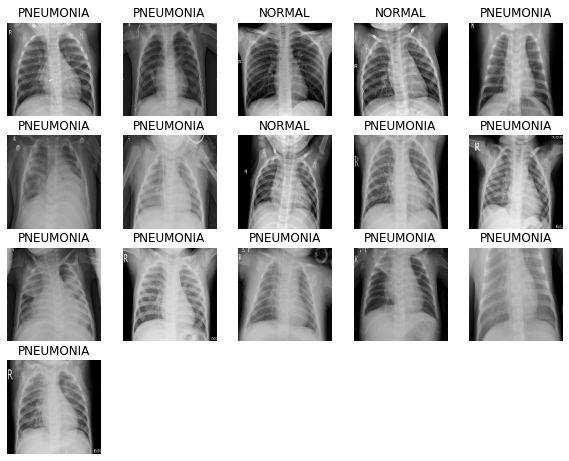

In [16]:
# basic

image_batch, label_batch = next(iter(train_ds_basic))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    print(image_batch.shape)
    print(label_batch.shape)
    for n in range(16):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch(image_batch.numpy(), label_batch.numpy())

(16, 180, 180, 3)
(16,)


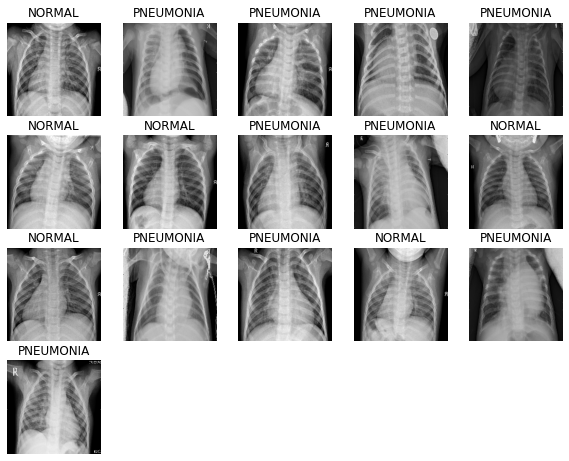

In [17]:
# augment

image_aug_batch, label_aug_batch = next(iter(train_aug_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    print(image_batch.shape)
    print(label_batch.shape)
    for n in range(16):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch(image_aug_batch.numpy(), label_aug_batch.numpy())

# 4. CNN 모델링

In [18]:
def conv_block(layer, filters):
    x = tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same')(layer)
    x = tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D()(x)

    return x

In [19]:
def dense_block(layer, units, dropout_rate=0.5, dropout=True):
    x = tf.keras.layers.Dense(units, activation='relu')(layer)
    x = tf.keras.layers.BatchNormalization()(x)
    if dropout:
        x = tf.keras.layers.Dropout(dropout_rate)(x)
    
    return x

In [20]:
def build_model(dropout=True):
    input_layer = tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    
    x = tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same')(input_layer)
    x = tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPool2D()(x)
    
    x = conv_block(x, 32)
    x = conv_block(x, 64)
    
    x = conv_block(x, 128)
    if dropout:
        x = tf.keras.layers.Dropout(0.2)(x)
    
    x = conv_block(x, 256)
    if dropout:
        x = tf.keras.layers.Dropout(0.2)(x)
    
    x = tf.keras.layers.Flatten()(x)
    x = dense_block(x, 512, 0.7)
    x = dense_block(x, 128, 0.5)
    x = dense_block(x, 64, 0.3)
    
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    
    model = tf.keras.Model(inputs=input_layer, outputs=output)
    
    return model

# 5. 데이터 imbalance 처리

In [21]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.95
Weight for class 1: 0.67


# 6. 모델 훈련

이미지의 라벨이 두 개밖에 없기 때문에 "binary_cross entropy" loss를 사용

optimizer로 'adam'을 사용하고, 성과에 대해서 측정하기 위한 metrics으로 'accuracy', 'precision', 'recall'을 사용

In [22]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [23]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds_basic,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds_basic,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/20
261/261 [==============================] - 85s 195ms/step - loss: 0.4266 - accuracy: 0.7933 - precision: 0.9456 - recall: 0.7663 - val_loss: 0.6726 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/20
261/261 [==============================] - 50s 191ms/step - loss: 0.2538 - accuracy: 0.8994 - precision: 0.9703 - recall: 0.8922 - val_loss: 1.1933 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 3/20
261/261 [==============================] - 50s 194ms/step - loss: 0.2097 - accuracy: 0.9222 - precision: 0.9735 - recall: 0.9205 - val_loss: 0.1436 - val_accuracy: 0.9452 - val_precision: 0.9347 - val_recall: 0.9948
Epoch 4/20
261/261 [==============================] - 51s 196ms/step - loss: 0.1592 - accuracy: 0.9385 - precision: 0.9817 - recall: 0.9346 - val_loss: 0.1051 - val_accuracy: 0.9615 - val_precision: 0.9548 - val_recall: 0.9948
Epoch 5/20
261/261 [==============================] - 52s 200ms/step - loss: 0.1839 - accura

In [24]:
# basic + augmentation

with tf.device('/GPU:0'):
    model_aug = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model_aug.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999),
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [25]:
with tf.device('/GPU:0'):
    history_aug = model_aug.fit(
        train_aug_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_aug_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/20
261/261 [==============================] - 59s 192ms/step - loss: 0.3865 - accuracy: 0.8053 - precision: 0.9570 - recall: 0.7731 - val_loss: 0.6382 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/20
261/261 [==============================] - 50s 191ms/step - loss: 0.2282 - accuracy: 0.9128 - precision: 0.9712 - recall: 0.9099 - val_loss: 1.0538 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 3/20
261/261 [==============================] - 50s 192ms/step - loss: 0.2109 - accuracy: 0.9203 - precision: 0.9763 - recall: 0.9149 - val_loss: 1.3649 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 4/20
261/261 [==============================] - 50s 192ms/step - loss: 0.1964 - accuracy: 0.9284 - precision: 0.9786 - recall: 0.9242 - val_loss: 0.1967 - val_accuracy: 0.9212 - val_precision: 0.9985 - val_recall: 0.8940
Epoch 5/20
261/261 [==============================] - 51s 194ms/step - loss: 0.1717 - accura

**평가(evaluate)**

In [26]:
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 5s 113ms/step - loss: 0.5604 - accuracy: 0.8638 - precision: 0.8352 - recall: 0.9744


In [27]:
loss, acc, prec, rec = model_aug.evaluate(test_ds)

39/39 [==============================] - 4s 104ms/step - loss: 0.8446 - accuracy: 0.7788 - precision: 0.7471 - recall: 0.9769


# 7. 결과 확인

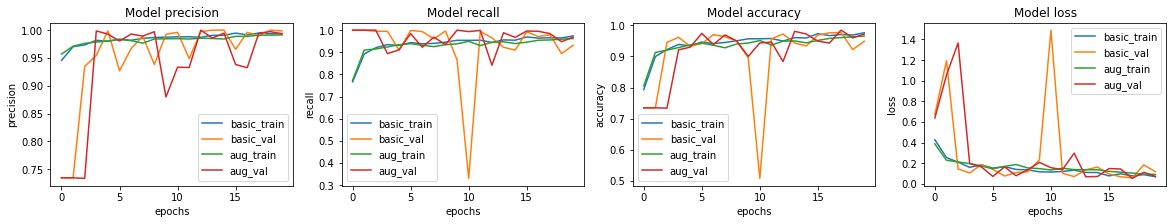

In [28]:
# basic vs augmentation

fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].plot(history_aug.history[met])
    ax[i].plot(history_aug.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['basic_train', 'basic_val', 'aug_train', 'aug_val'])

In [29]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 4s 108ms/step - loss: 0.5604 - accuracy: 0.8638 - precision: 0.8352 - recall: 0.9744
Loss: 0.5604339241981506,
Accuracy: 0.8637820482254028,
Precision: 0.8351648449897766,
Recall: 0.9743589758872986


# [E-09] 회고

펀디멘탈이 생각보다 일찍 정리를 다 해버려서 익스9번 과제를 하고 있었는데, 늘 그렇듯 초반에는 술술 잘 풀렸습니다😁
그래서 갑자기 이상하게 자신감이 차오르면서 충만해졌어요ㅋㅋㅋㅋ 수완님께 이번 과제 뭔가 잘 되고 있는 것 같다고 말했는데,
결과는 지켜봐야 안다고 하잖아요?

역시 새치혀를 함부로 놀린죄로 에러가 뜨더라구요ㅎ
테스트 데이터 셋에서 에러가 났었는데 원인을 찾아보니 단순히 경로 설정을 잘못했던 것이었습니다.
😂 후ㅎㅎ..., 그렇게 안심하고 계속 프로그램이 돌아가는 걸 보는데ㅎ
방심은 금물이라고😂😂 데이터 시각화에서 에러가 떴더라구요.

TypeError: Invalid shape (16, 180, 180, 3) for image data라고 이미지 데이터가 잘못된 모양이라고 뜨더라구요...
이걸로 잘 돌아갔었는데...
그래서ㅎ 제가 잘 하는 처음부터 다시 하기를 했습니다.

그거 아시나요? 아나 우당탕거리기 시작하면 다른 것도 삐걱대다가 우당탕 거린다는 사실...⭐
그래서 결국 다른 분의 코드를 참조했습니다.

https://github.com/JaeHeee/AIFFEL_Project/blob/master/EXPLORATION/EXPLORATION%2022.%20%ED%8F%90%EB%A0%B4%EC%95%84%20%EA%B8%B0%EB%8B%A4%EB%A0%A4%EB%9D%BC!.ipynb

그리고 코드를 보는데 이분이 신기한 것도 하셨더라고요 basic 모델이랑 augmentation한 모델을 더해서 돌려보셨길래 나중에 오답할 때 한 번 보려고 가지고 와봤습니다.

오늘도 다른분의 코드로 도움을 받아 과제를 어떻게 어떻게 해결했네요😅
늘어가는 건 오답밖에 없는 것 같습니다.